In [1]:
import pathlib
import os
from glob import glob

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 
import cloudpickle

import sklearn
from sklearn.linear_model import LinearRegression as LinReg


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [22]:
data_dict = {'date': "07_07_2023",
             'fly': "EPG_jGCaMP7f_CsChrimsontdT_fly4",
             'sessions': ('baseline-002',
                          'remap_0deg-005',
                          'remap_180deg-006'
                         ),
             'res': []
}


In [23]:

def make_h5(h5name, metadata):
    if not os.path.exists(h5name):
        tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                                metadata['size'],metadata['layout'])
        st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)
        
def calc_pva(dff):
    x_f,y_f = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])
    rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
    return rho, phi

def calc_offset(heading, pva_angle):
    _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),pva_angle-heading))
    return offset
    

def get_processed_data(date, fly, session):
    basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/')
    basename_input = pathlib.Path(basedir.joinpath(session))
    metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

    # raw data
    h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/data.h5'
    make_h5(h5name, metadata)
    f = h5py.File(h5name)
    data = f['/data'][:]
    
    # motion corrected
    ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
    data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[0,:,:,:], in_place=False)
    
    
    # ROI data
    napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/napari.pkl'
    with open(napari_outputs_file, 'rb') as file:
        np_layers = cloudpickle.load(file)
    masks = np_layers['rois']
    
    
    # voltage recording data
    csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/*.csv')
    vr_file = pathlib.Path(csv_files[0])
    df = dd.read_csv(vr_file).compute()
    
    # align voltage recording and imaging data
    frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
    df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)
    
    # extract fluorescence
    F, notF = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks, 16, max_proj=False) 
    for ch in range(F.shape[0]):
        lr = LinReg().fit(notF[ch,np.newaxis, :].T, F[ch,:,:].T)
        F[ch,:,:] = F[ch,:,:]-1.*lr.predict(notF[ch,np.newaxis,:].T).T  + lr.intercept_[:,np.newaxis]
    F = sp.ndimage.gaussian_filter1d(F,2,axis=-1) # smooth in time
    F = sp.ndimage.gaussian_filter1d(F,.5,axis=1, mode='wrap') # smooth in space
    
    dff = sp.stats.zscore(F[1,:,:],axis=-1) # z scored fluorescence with background subtraction
    
    
    # put heading back in correct range
    _, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           np.pi-1*df_aligned[' Heading'].to_numpy().ravel()))
    pva_amp, pva_angle = calc_pva(dff)
    offset = calc_offset(heading, pva_angle)
    
    return {'voltage_recording': df_aligned,
            'dff': dff,
            'heading': heading,
            'pva': {'amp': pva_amp, 'angle': pva_angle},
            'bump_offset': offset}




    

In [24]:
for sess in data_dict['sessions']:
    print(sess)
    data_dict['res'].append(get_processed_data(data_dict['date'], data_dict['fly'], sess))
# res = get_processed_data(data_dict['date'], data_dict['fly'], data_dict['sessions'][0])

baseline-002
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
remap_0deg-005
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
remap_180deg-006
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [25]:

fname = f"/media/mplitt/SSD_storage/2P_scratch/{data_dict['date']}/{data_dict['fly']}/combined_results.pkl"
with open(fname, 'wb') as file:
    cloudpickle.dump(data_dict,file)

In [26]:
# find indices where opto_trig > 0
opto_trig = np.concatenate([res['voltage_recording'][' Opto Trigger'] for res in data_dict['res']], axis=0)
opto_trig_filled = 1.*opto_trig
opto_inds = np.argwhere(opto_trig==1).ravel()
for ind in opto_inds.tolist():
    # find times within 5 seconds of opto trigger
    # make those values also 1
    opto_trig_filled[ind-50:ind+50]=1
    
    
starts = np.argwhere(st2p.preprocessing.signals.falling_edges(opto_trig_filled) > 0).ravel().tolist()
starts = (0, *starts)

stops = np.argwhere(st2p.preprocessing.signals.rising_edges(opto_trig_filled) > 0).ravel().tolist()
stops = (*stops, opto_trig_filled.shape[0])


In [27]:
print(starts,stops)

(0, 4451, 9700) (4231, 9480, 14364)


In [28]:
dff = np.concatenate([res['dff'] for res in data_dict['res']], axis=1)
pva_angle = np.concatenate([res['pva']['angle'] for res in data_dict['res']], axis=0)
heading = np.concatenate([res['heading'] for res in data_dict['res']], axis=0)

offset = np.concatenate([res['bump_offset'] for res in data_dict['res']], axis=0)


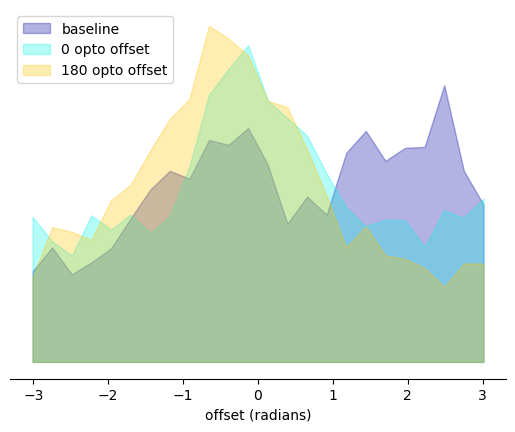

In [29]:
fig,ax = plt.subplots()
cmap = plt.cm.get_cmap('jet')
bin_edges = np.linspace(-np.pi, np.pi, num=25)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2.
labels = ('baseline', '0 opto offset', '180 opto offset')
for i, (start, stop) in enumerate(zip(starts,stops)):
    
    counts, _ = np.histogram(offset[start:stop],bins = bin_edges)
    ax.fill_between(bin_centers, counts/counts.sum(), alpha=.3, color=cmap(float(i+.1)/len(starts)), label=labels[i])
ax.legend(loc='upper left')

# ax.plot([0,0],[0,.1], color = cmap(.333))
# ax.plot([bin_centers[-1],bin_centers[-1]],[0,.1], color= cmap(.666))




ax.set_yticks([])
for s in ('top', 'left', 'right'):
    ax.spines[s].set_visible(False)
    
ax.set_xlabel('offset (radians)')

basedir = pathlib.PurePath(f"/media/mplitt/SSD_storage/fig_scratch/{data_dict['date']}/{data_dict['fly']}/figs")
os.makedirs(basedir, exist_ok=True)
fig_name = pathlib.Path(basedir.joinpath('offsets.png'))
fig.savefig(fig_name,format='png')



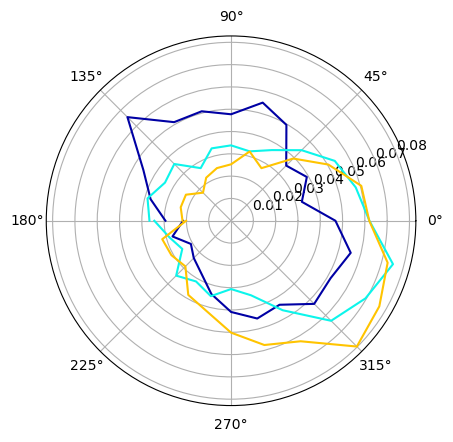

In [30]:
ax = plt.subplot(projection='polar')

cmap = plt.cm.get_cmap('jet')
bin_edges = np.linspace(-np.pi, np.pi, num=25)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2.
for i, (start, stop) in enumerate(zip(starts,stops)):
    
    counts, _ = np.histogram(offset[start:stop],bins = bin_edges)
    counts = counts/counts.sum()
    counts = [*counts.tolist(), (counts[0] + counts[-1])/2] 
    
    # ax.bar(bin_centers, counts, width=2*np.pi/25, bottom=0, alpha=.3, edgecolor=cmap(float(i+.1)/len(starts)),fill=False)
    ax.plot(bin_edges, counts, color=cmap(float(i+.1)/len(starts)))
    # ax.fill_between(bin_centers, counts/counts.sum(), alpha=.3, color=cmap(float(i+.1)/len(starts)))

1000 4231 (14364,)
5451 9480 (14364,)
10700 14364 (14364,)


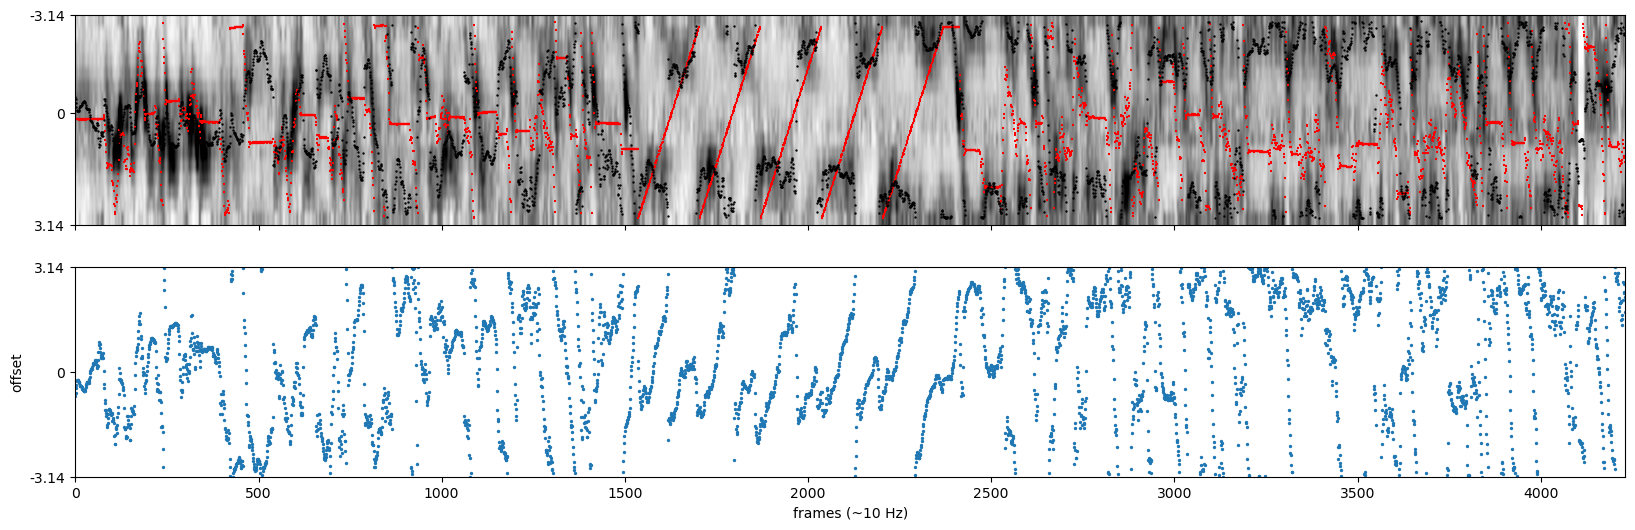

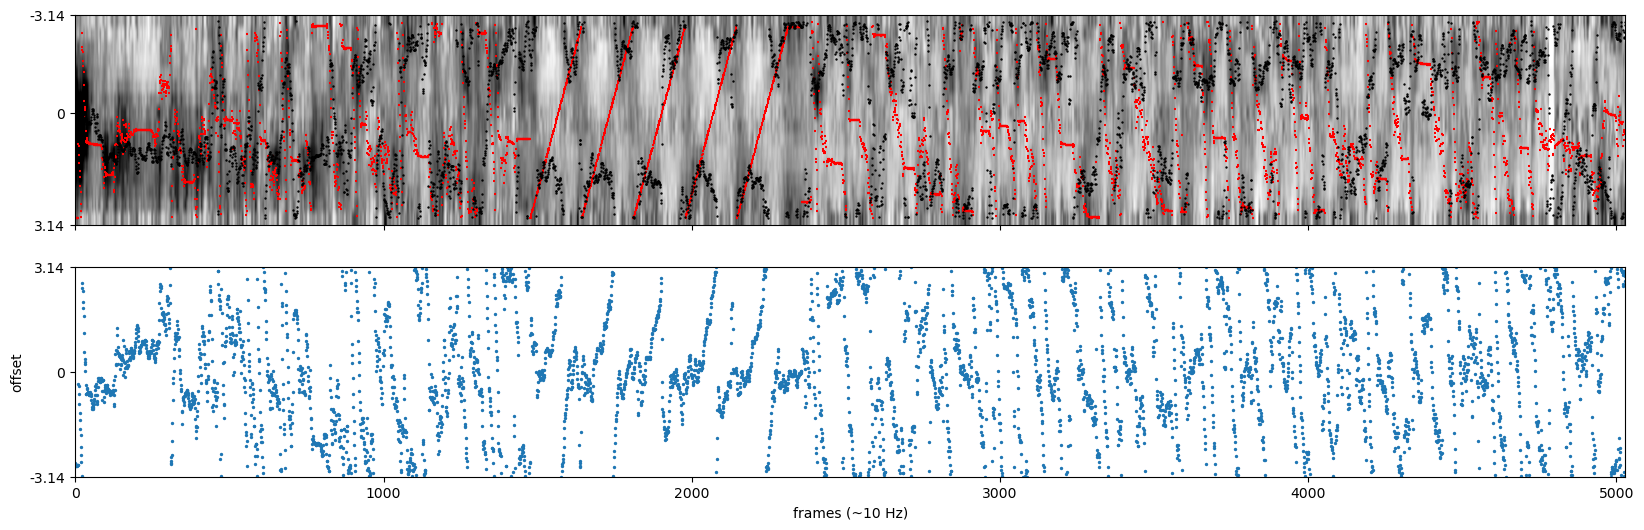

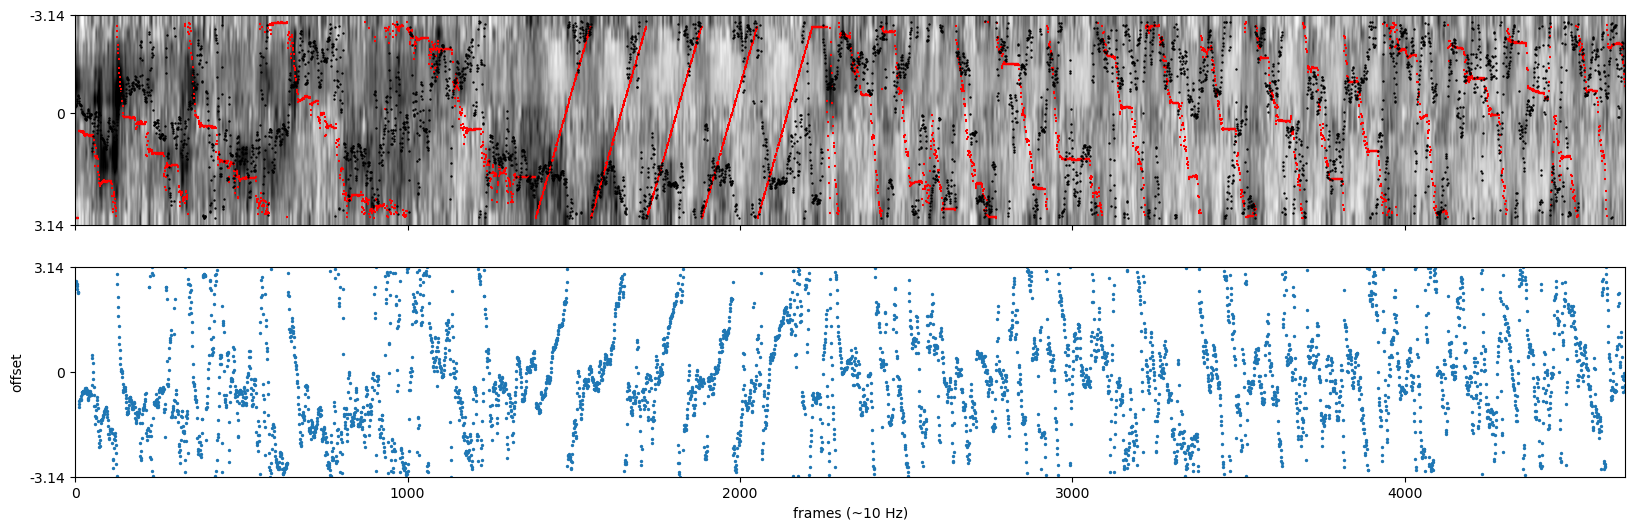

In [31]:
trim = 0
for i, (start, stop) in enumerate(zip(starts,stops)):
    window = slice(start+trim,stop)
    fig, ax = plt.subplots(2,1,figsize=[20,6], sharex=True)
    dff_window = dff[:,window]
    ax[0].imshow(dff_window,aspect='auto',cmap='Greys',vmin=-3,vmax=3)
    
    x = np.arange(stop-start-trim)
    print(start+1000,stop,heading.shape)
    ax[0].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='_', s=1)
    
    
    ax[0].scatter(x,15*(pva_angle[window]+np.pi)/2/np.pi,color='black', s=.5)
    ax[0].set_yticks([-.5, 7, 15.5])
    ax[0].set_yticklabels([-3.14, 0, 3.14])
    
    
    ax[1].scatter(x,offset[window],s=2)
    ax[1].set_ylim([-3.14,3.14])
    ax[1].set_yticks([-3.14,0,3.14])
    ax[1].set_yticklabels([-3.14, 0, 3.14])
    ax[1].set_ylabel('offset')
    ax[1].set_xlabel('frames (~10 Hz)')
    
    fig.savefig(basedir.joinpath(f'dff_{i}.png'),format='png')